# Seeing White<sup>*</sup> on a Map

This notebook demonstrates some of the data wrangling and mapping capabilities
of the `censusdis` package. It does the following:

1. Load metadata on the US Census redistricting data set from 2020
2. Load data on total population and the population of various ractial groups
   for every county in the United States
3. Determine the fraction of the population that is white
4. Plot the results on a map

In order to run this notebook, you will need a python virtual environment with Jupyter where you have also installed the [`censusdis` package](https://github.com/vengroff/censusdis) using 

```
pip install censusdis
```

----

<sup>*</sup>With apologies to the [Seeing White](https://www.sceneonradio.org/seeing-white/) podcast for borrowing the name.

## Basic imports

In [1]:
import censusdis.data as ced
import censusdis.maps as cdm
from censusdis.states import ALL_STATES_AND_DC

## Setup

For more details on what we are setting up here, see the comments 
in this [introductory notebook](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb).


In [2]:
CENSUS_API_KEY = None

In [3]:
YEAR = 2020
DATASET = "dec/pl"
GROUP = "P2"

## Fetch metadata

We will fetch the metadata on what fields are available and then select the ones
that represent the population count of people who identify as white, possibly mixed 
with one or more other races and those who identify as white alone.

In [4]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)
group = ced.variables.get_group(DATASET, YEAR, GROUP)

In [5]:
total_fields = [
    name
    for name, v in group.items()
    if v["label"].endswith("!!Total:") and not v["label"].startswith("Annotation")
]
total_fields

['P2_001N']

In [6]:
white_alone_fields = [
    name
    for name, v in group.items()
    if name in leaves and v["label"].endswith("White alone")
]
white_alone_fields

['P2_005N']

## Load data

Now that we know what fields we are interested in we can load data for those fields at the county level for all 50 states and DC.

In [7]:
df_counties = ced.download_detail(
    DATASET,
    YEAR,
    total_fields + white_alone_fields,
    state="*",
    county="*",
    api_key=CENSUS_API_KEY,
)

In [8]:
df_counties.head()

,STATE,COUNTY,P2_001N,P2_005N
0,01,001,58805,41582
1,01,003,231767,186495
2,01,005,25223,11086
3,01,007,22293,16442
4,01,009,59134,49764


## Summarize the white population

The next step is to total up the people who identify as white, possibly with other races,
and those who identify as white alone.

In [9]:
df_counties["white_alone"] = df_counties[white_alone_fields].sum(axis=1)

In [10]:
df_counties["pct_white_alone"] = 100.0 * (
    df_counties["white_alone"] / df_counties[total_fields[0]]
)

In [11]:
df_counties[total_fields + ["white_alone", "pct_white_alone"]].head()

,P2_001N,white_alone,pct_white_alone
0,58805,41582,70.711674
1,231767,186495,80.466589
2,25223,11086,43.951949
3,22293,16442,73.754093
4,59134,49764,84.154632


In [12]:
df_counties[["pct_white_alone"]].describe()

,pct_white_alone
count,3221.000000
mean,72.375220
std,22.579612
min,0.163068
25%,60.992094
50%,80.070468
75%,90.214840
max,97.404829


## Load shapefiles or used cached versions

In order to plot the data on a map, we need some shapefiles that
contain the boundaries of the counties and states we want to plot. The API
we will use will download the shapefiles from the US Census and cache 
them in a local directory pointed to by `SHAPEFILE_ROOT`.

If you want to browse available file you can look at the US Census 
[cartographic boundary page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html).

The specific zip files the code will download for us are the 2020 500,000:1 scale county and state
boundary files 
[`cb_2020_us_county_500k.zip`](https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip) and 
[`cb_2020_us_state_500k.zip`](https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip). 

In [13]:
import os
import os.path

SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

# Make sure it is there.
if not os.path.isdir(SHAPEFILE_ROOT):
    os.mkdir(SHAPEFILE_ROOT)

In [14]:
reader = cdm.ShapeReader(SHAPEFILE_ROOT, year=YEAR)

In [15]:
gdf_counties = reader.read_cb_shapefile("us", "county")
gdf_counties = gdf_counties[gdf_counties["STATEFP"].isin(ALL_STATES_AND_DC)]
gdf_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,01,053,00161552,0500000US01053,01053,Escambia,Escambia County,AL,Alabama,06,2448595161,20024887,"POLYGON ((-87.61558 31.12517, -87.61567 31.128..."
1,01,129,00161590,0500000US01129,01129,Washington,Washington County,AL,Alabama,06,2797712949,21660030,"POLYGON ((-88.46443 31.69795, -88.40541 31.697..."
2,01,113,00161583,0500000US01113,01113,Russell,Russell County,AL,Alabama,06,1660652494,15564412,"POLYGON ((-85.43472 32.31768, -85.43375 32.383..."
3,01,107,00161580,0500000US01107,01107,Pickens,Pickens County,AL,Alabama,06,2282835039,22621093,"POLYGON ((-88.34043 32.99120, -88.33101 33.072..."
4,01,119,00161585,0500000US01119,01119,Sumter,Sumter County,AL,Alabama,06,2340898913,24634883,"POLYGON ((-88.42082 32.31405, -88.41660 32.350..."


In [16]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[gdf_state_bounds["STATEFP"].isin(ALL_STATES_AND_DC)]

## Merge the shapefile and demographic data

Merge the two together so we have one `GeoDataFrame` that we can plot.

In [17]:
gdf_white_counties = gdf_counties.merge(
    df_counties[["STATE", "COUNTY", "pct_white_alone"]],
    left_on=["STATEFP", "COUNTYFP"],
    right_on=["STATE", "COUNTY"],
)

## Plot on a map

This is a basic plot, that you can style as you wish. Note that we use `cdm.plot_us` and `cdm.plot_us_boundary` because they take care of moving Alaska and Hawaii to a location 
where they are easy to visualize. If we did not do this, they would appear in their actual
geographic locations relatively far from the continental US.

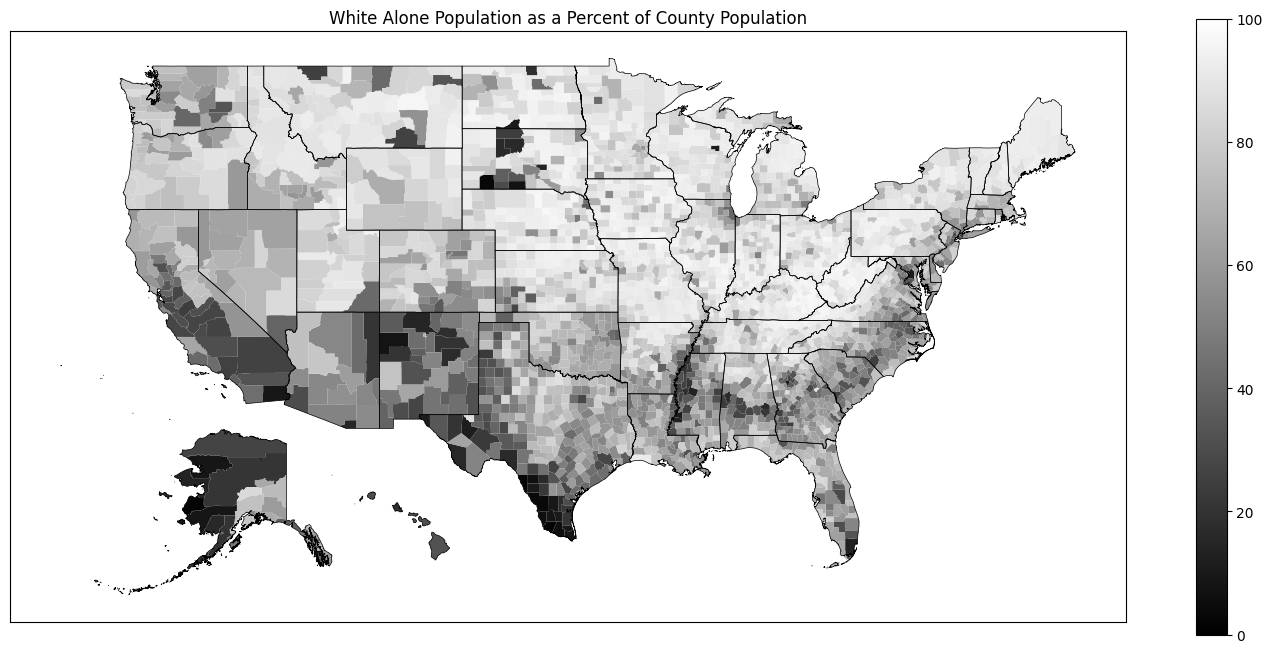

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18, 8)

col, name = "pct_white_alone", "White Alone"

ax = cdm.plot_us(
    gdf_white_counties,
    col,
    cmap="gray",
    legend=True,
    vmin=0.0,
    vmax=100.0,
)

ax = cdm.plot_us_boundary(gdf_state_bounds, edgecolor="black", linewidth=0.5, ax=ax)

ax.set_title(f"{name} Population as a Percent of County Population")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)